# Modelo de AI para Identificación de Carros - DL
Jorge de Jesús Castro Vázquez | A01707735

02/Junio/2025

# CODIGO

# Cargar Dataset de Google Drive

In [ ]:
# Instalar las dependências necessárias para o projeto
%pip install tensorflow  matplotlib pandas scikit-learn numpy 

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/376.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/376.0 MB 4.8 MB/s eta 0:01:18
   ---------------------------------------- 2.1/376.0 MB 5.6 MB/s eta 0:01:07
   ---------------------------------------- 3.7/376.0 MB 6.2 MB/s eta 0:01:00
    --------------------------------------- 5.5/376.0 MB 6.9 MB/s eta 0:00:55
    --------------------------------------- 6.8/376.0 MB 7.0 MB/s eta 0:00:53
    --------------------------------------- 7.9/376.0 MB 6.6 MB/s eta 0:00:56
    --------------------------------------- 8.7/376.0 MB 6.5 MB/s eta 0:00:57
   - -------------------------------------- 10.0/376.0 MB 6.1 MB/s eta 0:01:01
   - -------------------------------------- 11.3/376.0 MB 6.1 MB/s eta 0:01:00
   - -------------------------------------- 12.8/376.0 MB 6.3 MB/s eta 0:00:58
   - -------------------------------------- 14.7/376.0 MB 6.5 MB/s eta 0:00:56
   

ERROR: Could not install packages due to an OSError: [WinError 2] El sistema no puede encontrar el archivo especificado: 'c:\\Python312\\Scripts\\wheel.exe' -> 'c:\\Python312\\Scripts\\wheel.exe.deleteme'


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, optimizers
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report

### Declaración de Path, tamaño de imageen y verificación

In [2]:
train_dir = 'Cars Dataset Augmented/train'
test_dir = 'Cars Dataset Augmented/test'
val_dir = 'Cars Dataset Augmented/val'

IMG_SIZE=128

## Separación de Dataset a VAL 

In [3]:
# Este snippet fue hecho con Gemini AI para separar una cantidad de imagenes del TRAIN
# y usarlos como VAL del Modelo.
import shutil
import random


# Crear la carpeta en el path origen sí no existe
if not os.path.exists(val_dir):
  os.makedirs(val_dir)

# Leer la las classes que hay en el train
train_subdirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

# Indicar la cantidad de imagenes que se quieren para Val
num_images_per_class = 100

# Crear los directorios y
for subdir in train_subdirs:
  train_subdir_path = os.path.join(train_dir, subdir)
  val_subdir_path = os.path.join(val_dir, subdir)

  if not os.path.exists(val_subdir_path):
    os.makedirs(val_subdir_path)

  images = [f for f in os.listdir(train_subdir_path) if os.path.isfile(os.path.join(train_subdir_path, f))]

  # Seleccion random de 30 imagenes de cada subcarpeta
  selected_images = random.sample(images, min(num_images_per_class, len(images)))

  # Mover imagenes de train a val
  for image_name in selected_images:
    src_path = os.path.join(train_subdir_path, image_name)
    dest_path = os.path.join(val_subdir_path, image_name)
    shutil.move(src_path, dest_path)
    print(f"Moved {image_name} from {train_subdir_path} to {val_subdir_path}")

print("Validation dataset created successfully.")


Moved 340.jpg from Cars Dataset Augmented/train\Audi to Cars Dataset Augmented/val\Audi
Moved 1256.jpg from Cars Dataset Augmented/train\Audi to Cars Dataset Augmented/val\Audi
Moved 879.jpg from Cars Dataset Augmented/train\Audi to Cars Dataset Augmented/val\Audi
Moved 817.jpg from Cars Dataset Augmented/train\Audi to Cars Dataset Augmented/val\Audi
Moved 973.jpg from Cars Dataset Augmented/train\Audi to Cars Dataset Augmented/val\Audi
Moved 1048.jpg from Cars Dataset Augmented/train\Audi to Cars Dataset Augmented/val\Audi
Moved 662.jpg from Cars Dataset Augmented/train\Audi to Cars Dataset Augmented/val\Audi
Moved 304.jpg from Cars Dataset Augmented/train\Audi to Cars Dataset Augmented/val\Audi
Moved 473.jpg from Cars Dataset Augmented/train\Audi to Cars Dataset Augmented/val\Audi
Moved 979.jpg from Cars Dataset Augmented/train\Audi to Cars Dataset Augmented/val\Audi
Moved dt_aug_Audi__0_7980.jpeg from Cars Dataset Augmented/train\Audi to Cars Dataset Augmented/val\Audi
Moved 417.jpg

# Contar la cantidad de imágenes en cada carpeta

In [4]:
from prettytable import PrettyTable

def count_files_in_folders(directory):
  """
  Counts the number of files in each subfolder of a given directory.

  Args:
    directory (str): The path to the directory to analyze.

  Returns:
    list: A list of dictionaries, where each dictionary contains the
          'Folder Name' and 'File Count' for a subfolder.
  """
  folder_data = []
  for root, dirs, files in os.walk(directory):
    file_count = len(files)
    folder_data.append({'Folder Name': os.path.relpath(root, directory), 'File Count': file_count})
  return folder_data

def print_file_count_table(directory):
  """
  Prints a table showing the file count for each subfolder.

  Args:
    directory (str): The path to the directory to analyze.
  """
  folder_data = count_files_in_folders(directory)

  table = PrettyTable()
  table.field_names = ["Folder Name", "File Count"]

  for data in folder_data:
    table.add_row([data['Folder Name'], data['File Count']])

  print(table)

# Example usage with your train and test directories:
print("File counts in train directory:")
print_file_count_table(train_dir)

print("\nFile counts in test directory:")
print_file_count_table(test_dir)

print("\nFile counts in val directory:")
print_file_count_table(val_dir)


File counts in train directory:
+------------------+------------+
|   Folder Name    | File Count |
+------------------+------------+
|        .         |     0      |
|       Audi       |    720     |
|  Hyundai Creta   |    718     |
| Mahindra Scorpio |    720     |
|   Rolls Royce    |    720     |
|      Swift       |    720     |
|   Tata Safari    |    720     |
|  Toyota Innova   |    720     |
+------------------+------------+

File counts in test directory:
+------------------+------------+
|   Folder Name    | File Count |
+------------------+------------+
|        .         |     0      |
|       Audi       |    200     |
|  Hyundai Creta   |    200     |
| Mahindra Scorpio |    200     |
|   Rolls Royce    |    200     |
|      Swift       |    200     |
|   Tata Safari    |    200     |
|  Toyota Innova   |    200     |
+------------------+------------+

File counts in val directory:
+------------------+------------+
|   Folder Name    | File Count |
+------------------+-

# Configuración y Preparación de Dataset

## Configuración de Data Augmentation 
Se hace un reescalamiento, se aplica zoom, shear, horizontal flip y rotación

In [5]:
# Configuración del obejto ImageDataGenerator para aplicar augmentation
train_datagen = ImageDataGenerator(
							rescale = 1./255, # Reescalamiento de la imagen
							rotation_range = 10,
							width_shift_range = 0.1,
							height_shift_range = 0.1,
						  shear_range = 0.25,
							zoom_range = 0.3,
							horizontal_flip = True)

### Aplicar Data Augmentation

In [6]:
# 
train_generator = train_datagen.flow_from_directory(
							train_dir,
							target_size = (IMG_SIZE, IMG_SIZE),
							batch_size = 32,
							class_mode ='categorical',
							)
images, labels = train_generator[0]

print(f"Shape of images: {images.shape}")
print(f"Shape of labels: {labels.shape}")

Found 5038 images belonging to 7 classes.
Shape of images: (32, 128, 128, 3)
Shape of labels: (32, 7)


<Figure size 640x480 with 0 Axes>

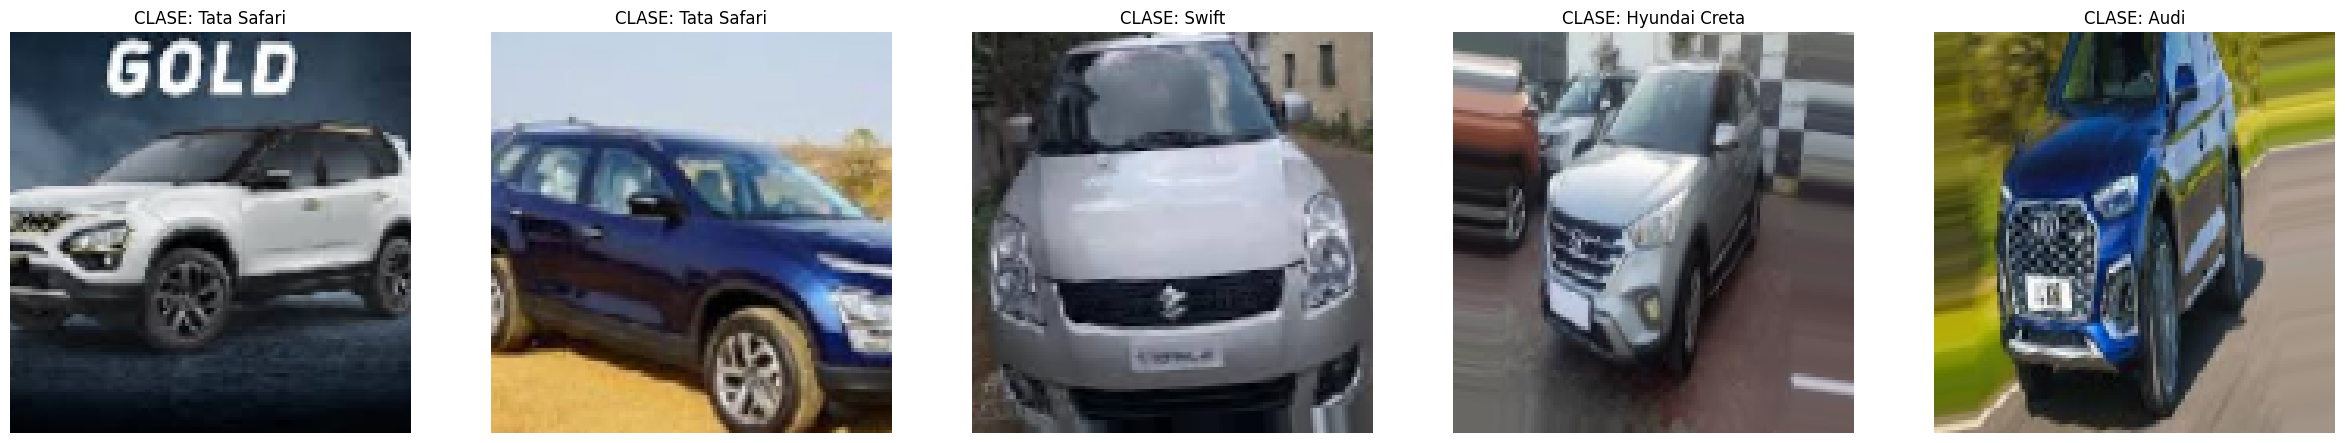

In [7]:
plt.figure()

f, axarr = plt.subplots(1, 5, figsize=(30, 8))
images, labels = train_generator[0]

# Mapa de Labels
label_map = {v: k for k, v in train_generator.class_indices.items()}

for i in range(5):
	axarr[i].imshow(images[i])
	class_index = tf.argmax(labels[i]).numpy()
	class_name = label_map[class_index]
	axarr[i].set_title(f"CLASE: {class_name}")
	axarr[i].axis('off')

In [8]:
# Preparación de los generadores de validación y test para métricas y evaluación
rescale_images_config = ImageDataGenerator(rescale=1./255)

val_rescale_generator = rescale_images_config.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=16,
    class_mode='categorical',
    shuffle=False  # No mezclar las imágenes para mantener el orden
)

test_rescale_generator = rescale_images_config.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=16,
    class_mode='categorical',
    shuffle=False  # No mezclar las imágenes para mantener el orden
)

Found 910 images belonging to 7 classes.
Found 1400 images belonging to 7 classes.


## Pimer Arquitectura de CNN [Kaggle]

In [9]:
img_shape = (IMG_SIZE, IMG_SIZE, 3)
model_kaggle = models.Sequential()

## Compilación del modelo

In [10]:
# Construcción de la Red Neuronal Kaggle
img_shape = (IMG_SIZE, IMG_SIZE, 3)
model_kaggle = models.Sequential()

model_kaggle.add(Conv2D(32, (3, 3), input_shape=img_shape, activation='relu'))
model_kaggle.add(MaxPooling2D(pool_size=(2, 2)))

model_kaggle.add(Conv2D(32, (3, 3), activation='relu'))
model_kaggle.add(MaxPooling2D(pool_size=(2, 2)))

model_kaggle.add(Flatten())

model_kaggle.add(Dense(units=96, activation='relu'))
model_kaggle.add(Dropout(0.40))
model_kaggle.add(Dense(units=32, activation='relu'))
model_kaggle.add(Dense(units=7, activation='softmax')) # softmax for more than 2

model_kaggle.summary()

model_kaggle.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



c:\Users\CVJJ1\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 96)             │     2,764,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,778,375 (10.60 MB)

 Trainable params: 2,778,375 (10.60 MB)

 Non-trainable params: 0 (0.00 B)

## Clase auxiliar para guardar Test Performance

In [11]:
class TestPerformance(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        super().__init__()
        self.test_data = test_data
        self.test_losses = []
        self.test_accs   = []

    def on_epoch_end(self, epoch, logs=None):
        loss, acc = self.model.evaluate(
            self.test_data,
            verbose=0
        )
        self.test_losses.append(loss)
        self.test_accs.append(acc)
        logs = logs or {}
        logs["test_loss"] = loss
        logs["test_accuracy"] = acc

test_callback_base = TestPerformance(test_data=test_rescale_generator)
test_callback_optimized = TestPerformance(test_data=test_rescale_generator)

## Entrenamiento del Modelo Kaggle

In [12]:
history_base = model_kaggle.fit(
    train_generator,
    epochs=50,
    validation_data=val_rescale_generator,
    callbacks=[test_callback_base],
)

c:\Users\CVJJ1\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 63s 353ms/step - accuracy: 0.1775 - loss: 1.9657 - val_accuracy: 0.2187 - val_loss: 1.8450 - test_loss: 1.8297 - test_accuracy: 0.2129
Epoch 2/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 53s 332ms/step - accuracy: 0.2532 - loss: 1.8287 - val_accuracy: 0.3231 - val_loss: 1.7276 - test_loss: 1.7293 - test_accuracy: 0.3207
Epoch 3/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 59s 377ms/step - accuracy: 0.3209 - loss: 1.7479 - val_accuracy: 0.3418 - val_loss: 1.6883 - test_loss: 1.6975 - test_accuracy: 0.3521
Epoch 4/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 60s 381ms/step - accuracy: 0.3387 - loss: 1.7142 - val_accuracy: 0.4286 - val_loss: 1.5669 - test_loss: 1.5765 - test_accuracy: 0.4057
Epoch 5/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 61s 388ms/step - accuracy: 0.3576 - loss: 1.6521 - val_accuracy: 0.4659 - val_loss: 1.4740 - test_loss: 1.4922 - test_accuracy: 0.4193
Epoch 6/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 60s 380ms/step - accuracy: 0.3969 - loss: 1.5778 - val_accuracy: 0.4846 - val_loss: 1

In [14]:
model_kaggle.save('model_kaggle_augmented.keras')

## Métricas del Modelo Kaggle

88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.6762 - loss: 1.0006
Test accuracy: 0.6435714364051819
                  precision    recall  f1-score   support

            Audi       0.50      0.90      0.65       200
   Hyundai Creta       0.80      0.47      0.59       200
Mahindra Scorpio       0.68      0.56      0.62       200
     Rolls Royce       0.60      0.47      0.53       200
           Swift       0.75      0.58      0.66       200
     Tata Safari       0.78      0.73      0.76       200
   Toyota Innova       0.60      0.80      0.68       200

        accuracy                           0.64      1400
       macro avg       0.67      0.64      0.64      1400
    weighted avg       0.67      0.64      0.64      1400



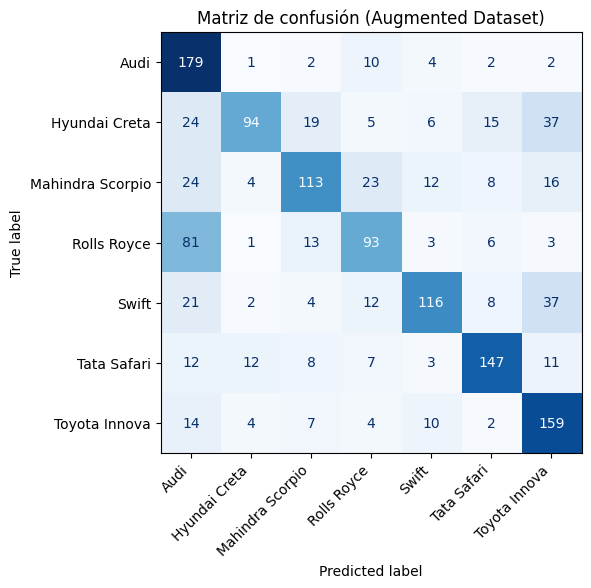

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_loss, test_acc = model_kaggle.evaluate(test_rescale_generator)
print(f"Test accuracy: {test_acc}")

labels = list(test_rescale_generator.class_indices.keys())

y_true = test_rescale_generator.classes
y_pred = np.argmax(model_kaggle.predict(test_rescale_generator, verbose=0), axis=1)

# Generación de la matriz de confusión y reporte de clasificación
cm = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred, target_names=labels))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure(figsize=(6, 6))
disp.plot(include_values=True, cmap=plt.cm.Blues, ax=plt.gca(), colorbar=False)
plt.title("Matriz de confusión (Augmented Dataset)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## Gráficas y Visualización de Resultados

In [16]:
test_loss, test_acc = model_kaggle.evaluate(test_rescale_generator)
print(f"Test accuracy: {test_acc} | Test loss: {test_loss}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.6762 - loss: 1.0006
Test accuracy: 0.6435714364051819 | Test loss: 1.1080074310302734


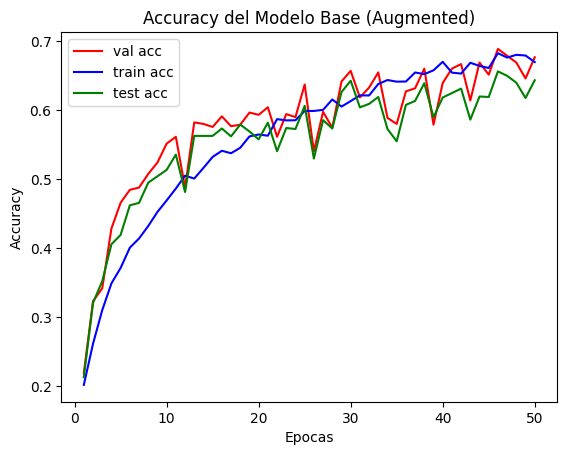

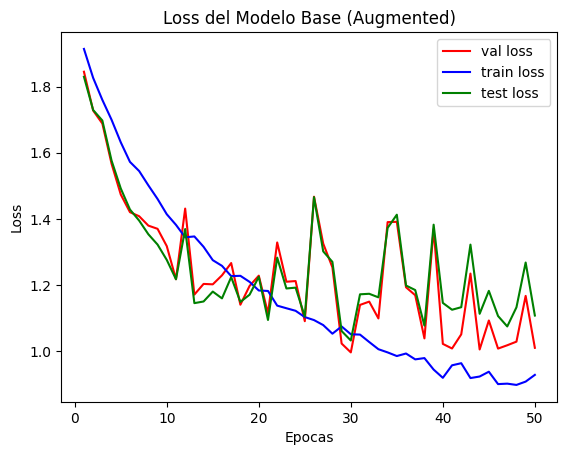

In [17]:
# Declarar los valores a gráficar: Train y Val. Test se evaluó anterioremente
train_accuracy = history_base.history['accuracy']
train_loss = history_base.history['loss']

val_accuracy = history_base.history['val_accuracy']
val_loss = history_base.history['val_loss']

num_epochs = range(1, len(train_accuracy) + 1)

# Graficar Accuracy del Modelo
plt.figure()

# Definir las Series que vamos a graficar
plt.plot(num_epochs, val_accuracy, 'r', label='val acc')
plt.plot(num_epochs, train_accuracy, 'b', label='train acc')
plt.plot(num_epochs, test_callback_base.test_accs, 'g', label='test acc')

# Configuración de Labels y Titulo de la gráfica
plt.title('Accuracy del Modelo Base (Augmented)')
plt.xlabel('Epocas')
plt.ylabel('Accuracy')
plt.legend()

# Graficar Loss del Modelo
plt.figure()

# Definir las Series que vamos a graficar
plt.plot(num_epochs, val_loss, 'r', label='val loss')
plt.plot(num_epochs, train_loss, 'b', label='train loss')
plt.plot(num_epochs, test_callback_base.test_losses, 'g', label='test loss')

# Configuración de Labels y título de gráfico
plt.title('Loss del Modelo Base (Augmented)')
plt.xlabel('Epocas')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Segundo Modelo Ajustado [Optimized]

## Segunda Arquitectura de CNN [Optimized]

In [18]:
img_shape = (IMG_SIZE, IMG_SIZE, 3)
model_optimized = models.Sequential()

model_optimized.add(Conv2D(16,(3, 3),activation="relu", kernel_constraint=max_norm(3), input_shape=img_shape))
model_optimized.add(MaxPooling2D((2, 2)))

model_optimized.add(Conv2D(32, (3, 3),activation="relu", kernel_constraint=max_norm(3), input_shape=img_shape))
model_optimized.add(MaxPooling2D((2, 2)))

model_optimized.add(Conv2D(64, (3, 3),activation="relu", kernel_constraint=max_norm(3)))
model_optimized.add(MaxPooling2D((2, 2)))

model_optimized.add(Dropout(0.2))

model_optimized.add(Conv2D(128, (3, 3), activation="relu", kernel_constraint=max_norm(3)))
model_optimized.add(MaxPooling2D((2, 2)))

model_optimized.add(Flatten())

model_optimized.add(Dropout(0.5))
model_optimized.add(Dense(512, activation='relu'))
model_optimized.add(Dense(7, activation='softmax'))

model_optimized.summary()

c:\Users\CVJJ1\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,460,839 (9.39 MB)

 Trainable params: 2,460,839 (9.39 MB)

 Non-trainable params: 0 (0.00 B)

## Compilación del modelo ajustado

In [19]:
model_optimized.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Entrenamiendo del Modelo Optimizado

In [20]:
history_optimized = model_optimized.fit(
    train_generator,
    epochs= 50, 
    validation_data=val_rescale_generator,
    callbacks=[test_callback_optimized])

Epoch 1/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 62s 376ms/step - accuracy: 0.1796 - loss: 1.9207 - val_accuracy: 0.3209 - val_loss: 1.7833 - test_loss: 1.7873 - test_accuracy: 0.3200
Epoch 2/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 58s 363ms/step - accuracy: 0.2848 - loss: 1.7983 - val_accuracy: 0.3165 - val_loss: 1.7363 - test_loss: 1.7128 - test_accuracy: 0.3136
Epoch 3/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 55s 345ms/step - accuracy: 0.3208 - loss: 1.7120 - val_accuracy: 0.3802 - val_loss: 1.6073 - test_loss: 1.6026 - test_accuracy: 0.3950
Epoch 4/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 49s 309ms/step - accuracy: 0.3876 - loss: 1.6038 - val_accuracy: 0.4275 - val_loss: 1.5029 - test_loss: 1.4573 - test_accuracy: 0.4364
Epoch 5/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 54s 342ms/step - accuracy: 0.4296 - loss: 1.4855 - val_accuracy: 0.5209 - val_loss: 1.3305 - test_loss: 1.2801 - test_accuracy: 0.5343
Epoch 6/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 46s 289ms/step - accuracy: 0.4948 - loss: 1.3846 - val_accuracy: 0.5308 - val_loss: 1

In [21]:
model_optimized.save("model_optimized_augmented.keras")

## Métricas del modelo Optimizado

88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.8164 - loss: 0.6294
Test accuracy: 0.8178571462631226
                  precision    recall  f1-score   support

            Audi       0.67      0.91      0.77       200
   Hyundai Creta       0.93      0.68      0.78       200
Mahindra Scorpio       0.84      0.84      0.84       200
     Rolls Royce       0.81      0.62      0.71       200
           Swift       0.89      0.85      0.87       200
     Tata Safari       0.87      0.91      0.89       200
   Toyota Innova       0.79      0.93      0.85       200

        accuracy                           0.82      1400
       macro avg       0.83      0.82      0.82      1400
    weighted avg       0.83      0.82      0.82      1400



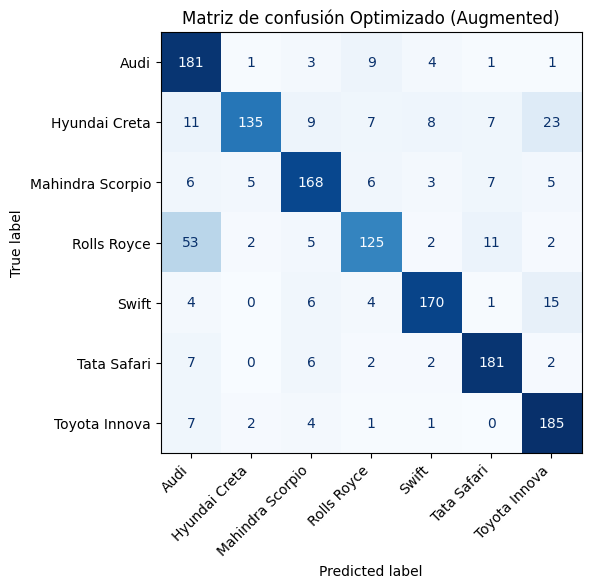

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_loss, test_acc = model_optimized.evaluate(test_rescale_generator)
print(f"Test accuracy: {test_acc}")

labels = list(test_rescale_generator.class_indices.keys())

y_true = test_rescale_generator.classes
y_pred = np.argmax(model_optimized.predict(test_rescale_generator, verbose=0), axis=1)

# Generación de la matriz de confusión y reporte de clasificación
cm = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred, target_names=labels))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure(figsize=(6, 6))
disp.plot(include_values=True, cmap=plt.cm.Blues, ax=plt.gca(), colorbar=False)
plt.title("Matriz de confusión Optimizado (Augmented)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## Gráficas y Visualización de Resultados

In [23]:
test_loss, test_acc = model_optimized.evaluate(test_rescale_generator)
print(f"Test accuracy: {test_acc} | Test loss: {test_loss}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.8164 - loss: 0.6294
Test accuracy: 0.8178571462631226 | Test loss: 0.6323457956314087


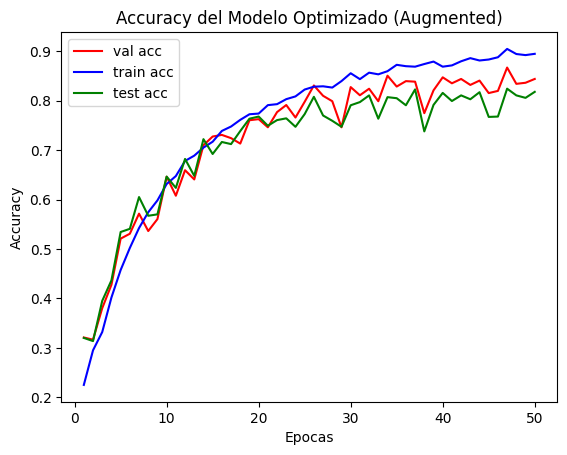

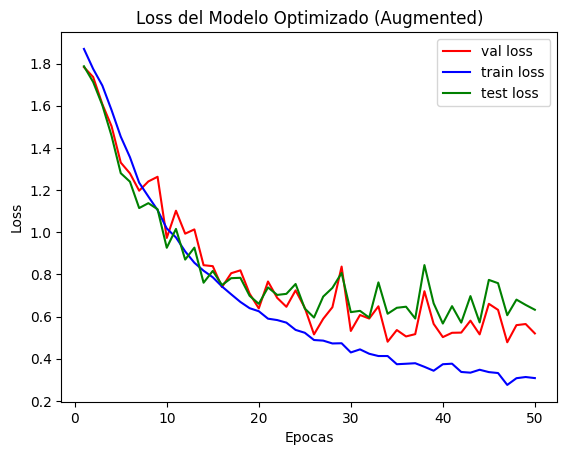

In [24]:
# Declarar los valores a gráficar: Train y Val. Test se evaluó anterioremente
train_accuracy = history_optimized.history['accuracy']
train_loss = history_optimized.history['loss']

val_accuracy = history_optimized.history['val_accuracy']
val_loss = history_optimized.history['val_loss']

num_epochs = range(1, len(train_accuracy) + 1)

# Graficar Accuracy del Modelo
plt.figure()

# Definir las Series que vamos a graficar
plt.plot(num_epochs, val_accuracy, 'r', label='val acc')
plt.plot(num_epochs, train_accuracy, 'b', label='train acc')
plt.plot(num_epochs, test_callback_optimized.test_accs, 'g', label='test acc')

# Configuración de Labels y Titulo de la gráfica
plt.title('Accuracy del Modelo Optimizado (Augmented)')
plt.xlabel('Epocas')
plt.ylabel('Accuracy')
plt.legend()

# Graficar Loss del Modelo
plt.figure()

# Definir las Series que vamos a graficar
plt.plot(num_epochs, val_loss, 'r', label='val loss')
plt.plot(num_epochs, train_loss, 'b', label='train loss')
plt.plot(num_epochs, test_callback_optimized.test_losses, 'g', label='test loss')

# Configuración de Labels y título de gráfico
plt.title('Loss del Modelo Optimizado (Augmented)')
plt.xlabel('Epocas')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Zona de Predicciónes

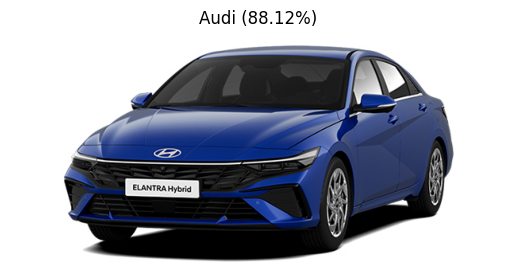

In [ ]:
import json, numpy as np, tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt

# --- 1. Carga del modelo y diccionario de clases ----------------------------
model_path   = Path("model_optimized_augmented.keras")                
#model_path   = Path("model_kaggle_augmented.keras")                

model = tf.keras.models.load_model(model_path)

# --- 2. Función auxiliar para pre-procesar y predecir ------------------------
def predict_image(img_path):

    img = tf.keras.utils.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    x   = tf.keras.utils.img_to_array(img) / 255.0  
    x   = np.expand_dims(x, axis=0)                       

    preds = model.predict(x, verbose=0)
    class_id = int(np.argmax(preds))
    conf     = float(np.max(preds))

    return label_map[class_id], conf, preds[0]

# --- 3. Elegir una imagen local ---------------------------------------------
img_path = Path("Pruebas/hyundai.jpg")     

assert img_path.exists(), f"No se encontró {img_path}"

predicted_class, confidence, prob_vector = predict_image(img_path)

# --- 4. Mostrar resultado ----------------------------------------------------
plt.imshow(tf.keras.utils.load_img(img_path))
plt.axis("off")
plt.title(f"{predicted_class} ({confidence:.2%})")
plt.show()
